# This code is a simple introduction to Cpx-Liquid melt matching
- for a more advanced example, see Cpx_MeltMatch2_ScruggsPutirka
- This notebook recreates the method of Gleeson et al. (2020) - JPET - https://doi.org/10.1093/petrology/egaa094

#### You need to install Thermobar once on your machine, if you haven't done this yet, uncomment the line below (remove the #)

In [1]:
#!pip install Thermobar

## This imports all the python things you need

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Thermobar as pt

## This sets plotting parameters

In [3]:
# This sets some plotting things
plt.rcParams["font.family"] = 'arial'
plt.rcParams["font.size"] =12
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["mathtext.fontset"] = "dejavusans"
plt.rcParams['patch.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1 
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 6 # Sets length of ticks
plt.rcParams["ytick.major.size"] = 4 # Sets length of ticks
plt.rcParams["ytick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["xtick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["axes.titlesize"] = 14 # Overall title
plt.rcParams["axes.labelsize"] = 14 # Axes labels



# Loading in Data
- In this case, Gleeson et al (2020) had cpxs in the sheet "cpxs" and liquids in the "melts" tab
- You column headings need to be "Sample_ID", "SiO2_Liq", "MgO_Cpx" etc. e.g., oxide, then underscore, capital letter for phase

In [4]:
# Loading Liquids
out=pt.import_excel('Gleeson2020JPET_Input_Pyroxene_Melts.xlsx', sheet_name="Melts")
my_input_Liqs=out['my_input']
myLiquids1=out['Liqs']

out2=pt.import_excel('Gleeson2020JPET_Input_Pyroxene_Melts.xlsx', sheet_name="Cpxs")
my_input_Cpxs=out2['my_input']
myCPXs1=out2['Cpxs']


# This loads in published barometry from Gleeson et al. You can delete this from your system, or swap it for something else useful. 
Published=pd.read_excel('Gleeson2020JPET_Input_Pyroxene_Melts.xlsx', sheet_name="NP_Out")


In [5]:
# You can check inputs have read in right using .head()
display(myLiquids1.head())
display(myCPXs1.head())

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,Cr2O3_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq,NiO_Liq,CoO_Liq,CO2_Liq,Sample_ID_Liq
0,47.1519,1.7168,15.5321,9.7208,0.1888,5.939515,12.3617,3.7556,1.1877,0.0,0.2766,0.0,0.0,0.0,0.0,0.0,17MMSG12_1
1,46.7277,1.7708,15.4931,9.5435,0.2096,6.098350,12.3699,3.7058,1.2644,0.0,0.1887,0.0,0.0,0.0,0.0,0.0,17MMSG12_2
2,47.5265,1.8483,15.7152,9.6930,0.1678,6.184563,12.3625,3.5107,1.2066,0.0,0.2055,0.0,0.0,0.0,0.0,0.0,17MMSG12_3
3,47.2916,1.7307,15.5250,9.3999,0.1588,6.322718,12.3696,3.9281,1.2285,0.0,0.2406,0.0,0.0,0.0,0.0,0.0,17MMSG12_4
4,47.2260,1.8009,15.6438,9.0440,0.2213,6.069612,12.4081,3.8352,1.1339,0.0,0.1894,0.0,0.0,0.0,0.0,0.0,17MMSG12_5


,SiO2_Cpx,TiO2_Cpx,Al2O3_Cpx,FeOt_Cpx,MnO_Cpx,MgO_Cpx,CaO_Cpx,Na2O_Cpx,K2O_Cpx,Cr2O3_Cpx,Sample_ID_Cpx
0,51.0169,0.5104,4.2921,3.9184,0.1135,15.9773,21.5003,0.3828,0.0,0.9642,17MMSG16_1
1,51.0208,0.5145,4.2768,3.7697,0.0917,15.9326,21.6712,0.3820,0.0,1.0514,17MMSG16_2
2,51.2990,0.4869,4.4177,3.7014,0.0983,15.9157,21.7450,0.3787,0.0,1.1905,17MMSG16_3
3,49.7147,0.7249,6.2489,3.9880,0.1128,15.0415,21.6397,0.4081,0.0,1.3550,17MMSG16_4
4,49.9807,0.7351,6.1948,4.0468,0.0951,14.9777,21.5061,0.3969,0.0,1.4862,17MMSG16_5


# Melt matching function
- Initially, we use the default, where all equilibrium criteria are considered.
- We specify the H2O content of the liquid is 0.5 wt%
- This returns a dictionary, containing 2 pandas dataframes. One labelled All_PTs gives the Pressures and temps for every single cpx-liq match,while Av_PTs averages all the parameters for each cpx. So if Cpx1 matches Liq1, Liq9, Liq 13, those three pressures and temperatures would be averaged

In [6]:
MM1=pt.calculate_cpx_liq_press_temp_matching(liq_comps=myLiquids1, cpx_comps=myCPXs1, 
                                        equationP="P_Neave2017", equationT="T_Put2008_eq33", 
                                         H2O_Liq=0.5)

# These lines extract pandas dataframes from the dictionary MM1
MM1_All=MM1['All_PTs']
MM1_Av=MM1['Av_PTs']

Considering 12714 Liq-Cpx pairs, be patient if this is >>1 million!
3631 Matches remaining after initial Kd filter. Now moving onto iterative calculations
Finished calculating Ps and Ts, now just averaging the results. Almost there!
Done!


In [7]:
MM1_Av

,Sample_ID_Cpx,Mean_T_K_calc,Std_T_K_calc,Mean_P_kbar_calc,Std_P_kbar_calc,ID_CPX,Mean_Delta_Kd_Put2008,Mean_Delta_Kd_Mas2013,Mean_Delta_EnFs,Mean_Delta_CaTs,...,Std_T_Liq_MinP,Std_T_Liq_MaxP,Std_Kd_MinP,Std_Kd_MaxP,Std_Kd_Ideal_Put,Std_Kd_Ideal_Masotta,Std_DiHd_Pred_Mollo,Std_EnFs_Pred_Mollo,Std_CaTs_Pred_P1999,Std_CrCaTS_Pred_P1999
0,17MMSG16_64,1483.741762,20.458238,5.774846,0.598899,63,0.011725,0.093742,0.034042,0.025290,...,15.729520,21.839097,0.003629,0.004369,0.004490,0.009827,0.013151,0.011676,0.000774,0.0
1,17MMSG16_65,1527.514642,7.965623,7.004365,0.163063,64,0.021093,0.078422,0.015337,0.029737,...,7.424701,10.375774,0.001689,0.002033,0.001712,0.003132,0.001465,0.005158,0.000236,0.0
2,17MMSG16_66,1524.073696,6.637660,6.419271,0.146893,65,0.025916,0.074755,0.005107,0.029778,...,5.015731,7.011010,0.001140,0.001373,0.001429,0.002584,0.002212,0.004697,0.000310,0.0


- Here, we inspect the average per Cpx, and see that only 3 Cpx analyses were found to have a match to any inputted liquid
- One Cpx matches 28 liquids, another Cpx matches 4 liquids, and the final one matches 2 liquids.
- You can tell from the Sample_ID_Cpx column which Cpxs these were (#64, 65, 66)

In [8]:
display(MM1_Av)

,Sample_ID_Cpx,Mean_T_K_calc,Std_T_K_calc,Mean_P_kbar_calc,Std_P_kbar_calc,ID_CPX,Mean_Delta_Kd_Put2008,Mean_Delta_Kd_Mas2013,Mean_Delta_EnFs,Mean_Delta_CaTs,...,Std_T_Liq_MinP,Std_T_Liq_MaxP,Std_Kd_MinP,Std_Kd_MaxP,Std_Kd_Ideal_Put,Std_Kd_Ideal_Masotta,Std_DiHd_Pred_Mollo,Std_EnFs_Pred_Mollo,Std_CaTs_Pred_P1999,Std_CrCaTS_Pred_P1999
0,17MMSG16_64,1483.741762,20.458238,5.774846,0.598899,63,0.011725,0.093742,0.034042,0.025290,...,15.729520,21.839097,0.003629,0.004369,0.004490,0.009827,0.013151,0.011676,0.000774,0.0
1,17MMSG16_65,1527.514642,7.965623,7.004365,0.163063,64,0.021093,0.078422,0.015337,0.029737,...,7.424701,10.375774,0.001689,0.002033,0.001712,0.003132,0.001465,0.005158,0.000236,0.0
2,17MMSG16_66,1524.073696,6.637660,6.419271,0.146893,65,0.025916,0.074755,0.005107,0.029778,...,5.015731,7.011010,0.001140,0.001373,0.001429,0.002584,0.002212,0.004697,0.000310,0.0


#### We can also run calculations at a fixed temperature

In [9]:
MM1_fixedT=pt.calculate_cpx_liq_press_temp_matching(liq_comps=myLiquids1, cpx_comps=myCPXs1, 
                                        equationP="P_Neave2017",T=1450, 
                                         H2O_Liq=0.5)

# These lines extract pandas dataframes from the dictionary MM1
MM1_All_fixedT=MM1_fixedT['All_PTs']
MM1_Av_fixedT=MM1_fixedT['Av_PTs']

Considering 12714 Liq-Cpx pairs, be patient if this is >>1 million!
Finished calculating Ps and Ts, now just averaging the results. Almost there!
Done!


In [10]:
MM1_All_fixedT.head()

,Sample_ID_Cpx,P_kbar_calc,T_K_input,Eq Tests Neave2017?,Delta_Kd_Put2008,Delta_Kd_Mas2013,Delta_EnFs,Delta_CaTs,Delta_DiHd,SiO2_Liq,...,Kd_Fe_Mg_IdealWB,Mgno_Liq_noFe3,Mgno_Liq_Fe2,DeltaFeMg_WB,Kd_Ideal_Put,Kd_Ideal_Masotta,DiHd_Pred_Mollo,EnFs_Pred_Mollo,CaTs_Pred_P1999,CrCaTS_Pred_P1999
10317,17MMSG16_64,6.898724,1450,True,0.025861,0.079702,0.013569,0.023827,0.046822,46.58,...,0.274423,0.666612,0.666612,0.025706,0.274579,0.169016,0.718665,0.131988,0.014860,0.0
10324,17MMSG16_64,5.621206,1450,True,0.009732,0.109236,0.043536,0.025944,0.016473,47.69,...,0.274423,0.695647,0.695647,0.009888,0.274579,0.175075,0.749014,0.161955,0.012743,0.0
10328,17MMSG16_64,6.562306,1450,True,0.001378,0.070648,0.007186,0.024758,0.015500,46.98,...,0.274423,0.687142,0.687142,0.001222,0.274579,0.202553,0.749987,0.125605,0.013928,0.0
10329,17MMSG16_64,5.461770,1450,True,0.008311,0.095186,0.000852,0.024891,0.000008,46.15,...,0.274423,0.681589,0.681589,0.008155,0.274579,0.171082,0.765479,0.119271,0.013796,0.0
10330,17MMSG16_64,5.573106,1450,True,0.017770,0.109354,0.038498,0.025572,0.011095,48.62,...,0.274423,0.701517,0.701517,0.017926,0.274579,0.182995,0.754392,0.156917,0.013115,0.0


### Or at fixed pressure

In [12]:
MM1_fixedP=pt.calculate_cpx_liq_press_temp_matching(liq_comps=myLiquids1, cpx_comps=myCPXs1, 
                                        P=5,equationT="T_Put2008_eq33",
                                         H2O_Liq=0.5)

# These lines extract pandas dataframes from the dictionary MM1
MM1_All_fixedP=MM1_fixedP['All_PTs']
MM1_Av_fixedP=MM1_fixedP['Av_PTs']

Considering 12714 Liq-Cpx pairs, be patient if this is >>1 million!
Finished calculating Ps and Ts, now just averaging the results. Almost there!
Done!


## We can also customize the function to get more matches
- Here, folowing Gleeson et al. 2020, we specify that we wish to consider pairs which pass the DiHd, CaTs and EnFs equilibrium tests with sigma = 2. 

In [9]:
MM1_2s=pt.calculate_cpx_liq_press_temp_matching(liq_comps=myLiquids1, cpx_comps=myCPXs1, 
                                        equationP="P_Neave2017", equationT="T_Put2008_eq33", 
                                        sigma=2, H2O_Liq=0.5)
# These lines extract pandas dataframes from the dictionary MM1
MM1_2s_All=MM1_2s['All_PTs']
MM1_2s_Av=MM1_2s['Av_PTs']

Considering 12714 Liq-Cpx pairs, be patient if this is >>1 million!
3631 Matches remaining after initial Kd filter. Now moving onto iterative calculations
Finished calculating Ps and Ts, now just averaging the results. Almost there!
Done!


## We see we get a lot more matches. 

In [10]:
MM1_2s_Av

,Sample_ID_Cpx,Mean_T_K_calc,Std_T_K_calc,Mean_P_kbar_calc,Std_P_kbar_calc,ID_CPX,Mean_Delta_Kd_Put2008,Mean_Delta_Kd_Mas2013,Mean_Delta_EnFs,Mean_Delta_CaTs,...,Std_T_Liq_MinP,Std_T_Liq_MaxP,Std_Kd_MinP,Std_Kd_MaxP,Std_Kd_Ideal_Put,Std_Kd_Ideal_Masotta,Std_DiHd_Pred_Mollo,Std_EnFs_Pred_Mollo,Std_CaTs_Pred_P1999,Std_CrCaTS_Pred_P1999
0,17MMSG16_1,1485.519680,24.340643,6.170410,0.696717,0,0.016247,0.108914,0.034125,0.033892,...,18.668627,25.901979,0.004313,0.005193,0.005341,0.012744,0.014562,0.015462,0.001054,0.0
1,17MMSG16_2,1482.135803,23.959272,6.086663,0.697191,1,0.013092,0.107312,0.039746,0.033041,...,18.566590,25.710441,0.004308,0.005187,0.005282,0.012621,0.015386,0.016380,0.001053,0.0
2,17MMSG16_3,1480.463839,21.147419,5.980043,0.702899,2,0.013416,0.106409,0.047317,0.037749,...,16.206649,22.479106,0.003747,0.004511,0.004645,0.012006,0.016481,0.016545,0.001088,0.0
3,17MMSG16_4,1508.719399,13.984144,7.269439,0.698513,3,0.016959,0.113074,0.041563,0.058418,...,10.383307,14.462498,0.002379,0.002864,0.003024,0.011597,0.017909,0.010652,0.001745,0.0
4,17MMSG16_5,1504.328416,12.762583,7.987680,0.609534,4,0.015726,0.112612,0.035519,0.057743,...,7.849398,10.900179,0.001810,0.002179,0.002778,0.016733,0.007930,0.017390,0.002786,0.0
5,17MMSG16_6,1470.584978,27.077445,6.456219,0.567048,5,0.016176,0.113280,0.057077,0.056981,...,22.015738,30.423319,0.005131,0.006178,0.005997,0.009982,0.023174,0.024957,0.002451,0.0
6,17MMSG16_7,1488.553479,NaN,7.293616,NaN,6,0.017285,0.106398,0.026222,0.058521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,17MMSG16_8,1497.604673,19.766538,7.291515,0.492287,7,0.017109,0.110788,0.028865,0.057226,...,16.704179,23.165961,0.003863,0.004651,0.004335,0.012509,0.025751,0.012967,0.002737,0.0
8,17MMSG16_9,1475.455204,31.363881,7.096252,0.811558,8,0.013055,0.110255,0.059124,0.055872,...,24.504227,33.831009,0.005722,0.006890,0.006947,0.009588,0.023075,0.019975,0.002361,0.0
9,17MMSG16_15,1488.969983,25.701543,6.688471,0.702623,14,0.016950,0.108501,0.044546,0.044944,...,19.784185,27.438972,0.004575,0.005508,0.005634,0.012693,0.014467,0.016332,0.001122,0.0


# Example 2 
- Say you want to used a fixed value for Kd Fe-Mg, rather than the default, which uses equation 35 of Putirka which is T dependent
- Here, specifying Kd Fe-Mg = 0.27, and you want to consider +-0.08 as an equilibrium match
- Also specifying here that Fe3Fet_Liq=0.15
- Also changing pressure equation to equation 30

In [11]:
# import warnings
# warnings.simplefilter("error")
# Doing same thing using Fe3/FeT=0.15
MM2=pt.calculate_cpx_liq_press_temp_matching(liq_comps=myLiquids1, cpx_comps=myCPXs1, 
                                        equationP="P_Put2008_eq30", equationT="T_Put2008_eq33", eq_crit="All", 
                                        KdMatch=0.27, KdErr=0.08, Fe3Fet_Liq=0.15, sigma=2)
MM2_All=MM2['All_PTs']
MM2_Av=MM2['Av_PTs']

Considering 12714 Liq-Cpx pairs, be patient if this is >>1 million!
the code is evaluating Kd matches using Kd=0.27
4172 Matches remaining after initial Kd filter. Now moving onto iterative calculations
Finished calculating Ps and Ts, now just averaging the results. Almost there!
Done!


# Example 3 - Alkaline Systems
- You might want to use the updated Kd model from Masotta valid for trachyte and phonolitic magmas.
- Here, you can change KdMatch to "Masotta"
- Might want to use P from P_Mas2013_Palk2012 and T_Mas2013_Talk2012

In [12]:

# Doing same thing using Fe3/FeT=0.15
MM3=pt.calculate_cpx_liq_press_temp_matching(liq_comps=myLiquids1, cpx_comps=myCPXs1, 
                                    equationP="P_Mas2013_Palk2012", equationT="T_Mas2013_Talk2012", eq_crit="All", 
                                    KdMatch="Masotta", KdErr=0.08, Fe3Fet_Liq=0.15, sigma=2)
MM3_All=MM3['All_PTs']
MM3_Av=MM3['Av_PTs']

Caution, you have selected to use the Kd-Fe-Mg model of Masotta et al. (2013)which is only valid for trachyte and phonolitic magmas.  use PutKd=True to use the Kd model of Putirka (2008)
Considering 12714 Liq-Cpx pairs, be patient if this is >>1 million!
Youve selected a P-independent function
Youve selected a P-independent function
2352 Matches remaining after initial Kd filter. Now moving onto iterative calculations
Youve selected a P-independent function
Youve selected a T-independent function
Youve selected a T-independent function
Finished calculating Ps and Ts, now just averaging the results. Almost there!
Done!


In [13]:
MM3_All.head()

,Sample_ID_Cpx,P_kbar_calc,T_K_calc,Eq Tests Neave2017?,Delta_Kd_Put2008,Delta_Kd_Mas2013,Delta_EnFs,Delta_CaTs,Delta_DiHd,SiO2_Liq,...,Mgno_Liq_Fe2,DeltaFeMg_WB,T_Liq_MinP,T_Liq_MaxP,Kd_Ideal_Put,Kd_Ideal_Masotta,DiHd_Pred_Mollo,EnFs_Pred_Mollo,CaTs_Pred_P1999,CrCaTS_Pred_P1999
0,17MMSG16_1,4.484954,1353.763834,False,0.076093,0.027189,0.028005,0.033390,0.023960,47.1519,...,0.561663,0.096211,1353.763834,1353.763834,0.252387,0.149104,0.782499,0.094081,0.014322,0.0
1,17MMSG16_1,4.536992,1359.812658,False,0.069446,0.030948,0.027431,0.033259,0.018175,46.7277,...,0.572660,0.088134,1359.812658,1359.812658,0.253816,0.153423,0.776714,0.094656,0.014452,0.0
2,17MMSG16_1,4.664336,1362.026843,False,0.070245,0.029827,0.024555,0.033089,0.012565,47.5265,...,0.572292,0.088411,1362.026843,1362.026843,0.254338,0.154266,0.771104,0.097532,0.014623,0.0
3,17MMSG16_1,4.521748,1361.019784,False,0.060027,0.043562,0.025938,0.033548,0.021885,47.2916,...,0.585163,0.078431,1361.019784,1361.019784,0.254101,0.150512,0.780424,0.096148,0.014163,0.0
4,17MMSG16_1,4.523901,1356.789776,False,0.059466,0.046108,0.028110,0.033104,0.018335,47.2260,...,0.584615,0.078868,1356.789776,1356.789776,0.253102,0.147528,0.776874,0.093976,0.014608,0.0


## Example 4 - Say you only want a KD filter, using the equation of Putirka
- KdMatch="Putirka" is actually a default option, so you don't have to type it

In [14]:
MM4=pt.calculate_cpx_liq_press_temp_matching(liq_comps=myLiquids1, cpx_comps=myCPXs1, 
                                        equationP="P_Mas2013_Palk2012", equationT="T_Mas2013_Talk2012", eq_crit="Kd", 
                                        KdMatch="Putirka", KdErr=0.03, Fe3Fet_Liq=0.15)
MM4_All=MM4['All_PTs']
MM4_Av=MM4['Av_PTs']

Considering 12714 Liq-Cpx pairs, be patient if this is >>1 million!
Youve selected a P-independent function
Youve selected a P-independent function
1514 Matches remaining after initial Kd filter. Now moving onto iterative calculations
Youve selected a P-independent function
Youve selected a T-independent function
Youve selected a T-independent function
Finished calculating Ps and Ts, now just averaging the results. Almost there!
Done!


## You can see the difference here between the default, and just a Kd filter in terms of # of matches and eq tests

Text(0.5, 0, 'ΔCaTs')

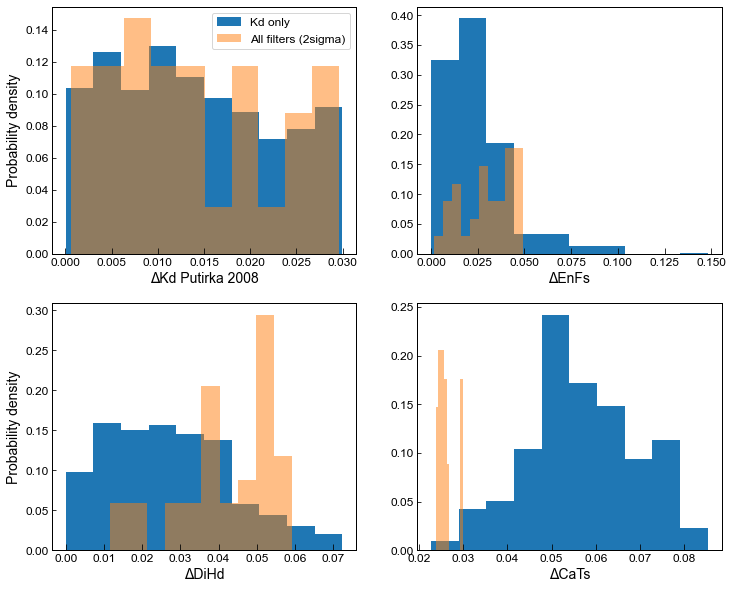

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
# This plots things with probability on the y axis
ax1.hist(MM4_All['Delta_Kd_Put2008'], weights=np.ones_like(MM4_All['Delta_Kd_Put2008']) / len(MM4_All['Delta_Kd_Put2008']), label='Kd only')
ax1.hist(MM1_All['Delta_Kd_Put2008'], weights=np.ones_like(MM1_All['Delta_Kd_Put2008']) / len(MM1_All['Delta_Kd_Put2008']) , label='All filters (2sigma)', alpha=0.5)
ax1.set_xlabel('ΔKd Putirka 2008')
ax1.set_ylabel('Probability density')
ax1.legend()

# This plots things with probability on the y axis
ax2.hist(MM4_All['Delta_EnFs'], weights=np.ones_like(MM4_All['Delta_EnFs']) / len(MM4_All['Delta_EnFs']) )#, label='All filters (2sigma)', color='salmon')
ax2.hist(MM1_All['Delta_EnFs'], weights=np.ones_like(MM1_All['Delta_EnFs']) / len(MM1_All['Delta_EnFs']), alpha=0.5)
ax2.set_xlabel('ΔEnFs')

# This plots things with probability on the y axis
ax3.hist(MM4_All['Delta_DiHd'], weights=np.ones_like(MM4_All['Delta_DiHd']) / len(MM4_All['Delta_DiHd']) )#, label='All filters (2sigma)', color='salmon')
ax3.hist(MM1_All['Delta_DiHd'], weights=np.ones_like(MM1_All['Delta_DiHd']) / len(MM1_All['Delta_DiHd']) , alpha=0.5)
ax3.set_xlabel('ΔDiHd')
ax3.set_ylabel('Probability density')
# This plots things with probability on the y axis
ax4.hist(MM4_All['Delta_CaTs'], weights=np.ones_like(MM4_All['Delta_CaTs']) / len(MM4_All['Delta_CaTs']) )#, label='All filters (2sigma)', color='salmon')
ax4.hist(MM1_All['Delta_CaTs'], weights=np.ones_like(MM1_All['Delta_CaTs']) / len(MM1_All['Delta_CaTs']), alpha=0.5)
ax4.set_xlabel('ΔCaTs')

# Plotting
- Here comparing first match, with sigma=1 and the second with sigma=2
- We show average for cpx with a diamond and error bar, as well as all matches as very faint dots


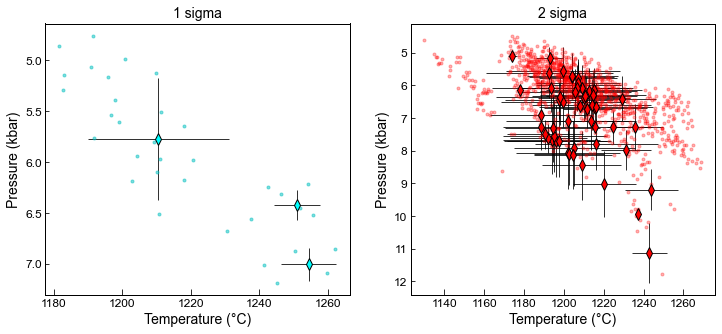

In [17]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 5))

# Subplot1
ax1.plot(MM1_All['T_K_calc']-273.15,  MM1_All['P_kbar_calc'], '.c', alpha=0.5)
ax1.errorbar(MM1_Av['Mean_T_K_calc']-273.15,  MM1_Av['Mean_P_kbar_calc'],
             xerr=MM1_Av['Std_T_K_calc'], yerr=MM1_Av['Std_P_kbar_calc'],
             fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=8, mec='k')
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Pressure (kbar)')
ax1.set_title('1 sigma')
# Subplot2
ax2.plot(MM1_2s_All['T_K_calc']-273.15,  MM1_2s_All['P_kbar_calc'], '.r', alpha=0.3)

ax2.errorbar(MM1_2s_Av['Mean_T_K_calc']-273.15,  MM1_2s_Av['Mean_P_kbar_calc'],
             xerr=MM1_2s_Av['Std_T_K_calc'], yerr=MM1_2s_Av['Std_P_kbar_calc'],
             fmt='d', ecolor='k', elinewidth=0.8, mfc='red', ms=8, mec='k')
ax2.set_xlabel('Temperature (°C)')
ax2.set_ylabel('Pressure (kbar)')
ax2.set_title('2 sigma')
ax1.invert_yaxis()
ax2.invert_yaxis()


## Here we compare to published data for Gleeson et al. (2020)
- The differences result from the fact that the R algorithm of D. Neave throws out matches before 
T and P are fully converged, and Kd is being calculated using Putirka (1996) in that code, rather than the user-selected thermometer

Text(0, 0.5, 'Pressure (kbar)')

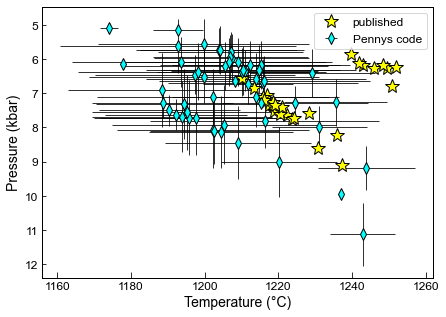

In [18]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5))

# Subplot1
ax1.errorbar(MM1_2s_Av['Mean_T_K_calc']-273.15,  MM1_2s_Av['Mean_P_kbar_calc'],
             xerr=MM1_2s_Av['Std_T_K_calc'], yerr=MM1_2s_Av['Std_P_kbar_calc'],
             fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=8, mec='k', label='Pennys code')
ax1.plot(Published['Temperature'], Published['Pressure'], '*k', markerfacecolor='yellow', markersize=15, label='published')
ax1.legend()
ax1.invert_yaxis()
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Pressure (kbar)')